In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain
from sklearn.metrics import make_scorer

In [2]:
from Feature_Engineering import feature_engineering

In [3]:
features = feature_engineering(j_flag=1) # For the full dataset

In [4]:
features.shape
recall_scores = pd.DataFrame(columns=('Model', 'Score'))

In [5]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [6]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [7]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [8]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,Procedure_5_Count,Diagnosis_1_Count,Diagnosis_2_Count,Diagnosis_3_Count,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count
0,0.470588,-0.017544,-0.155665,-0.077922,-0.165527,1.0,-0.100000,1.538462,-1.538462,0.0,...,0.0,-0.077170,-0.098039,-0.111111,-0.083333,0.0625,0.230769,0.0,-0.125,-0.142857
1,2.235294,1.614035,0.031527,1.311688,0.000000,12.4,0.614286,3.615385,-3.615385,0.0,...,0.0,1.311897,1.784314,2.166667,2.833333,3.6875,4.076923,5.2,5.875,6.142857
2,1.882353,1.982456,0.222660,1.532468,0.125855,0.0,1.742857,0.000000,0.000000,0.0,...,0.0,1.453376,1.372549,1.166667,1.000000,1.0625,0.846154,0.6,0.625,0.285714
3,0.000000,8.245614,15.763547,14.727273,26.151847,0.0,16.257143,0.000000,0.000000,4.0,...,0.0,14.392283,13.764706,12.250000,11.541667,9.8125,7.307692,6.5,5.000,3.428571
4,0.235294,0.578947,0.650246,0.532468,0.574555,0.6,0.600000,0.307692,-0.307692,0.0,...,0.0,0.540193,0.490196,0.416667,0.458333,0.4375,0.538462,0.6,0.375,0.428571


In [9]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Both_Service,Inpatient,Outpatient,isFraudConnected
0,0.470588,-0.017544,-0.155665,-0.077922,-0.165527,1.0,-0.100000,1.538462,-1.538462,0.0,...,-0.083333,0.0625,0.230769,0.0,-0.125,-0.142857,1,0,0,0.0
1,2.235294,1.614035,0.031527,1.311688,0.000000,12.4,0.614286,3.615385,-3.615385,0.0,...,2.833333,3.6875,4.076923,5.2,5.875,6.142857,1,0,0,0.0
2,1.882353,1.982456,0.222660,1.532468,0.125855,0.0,1.742857,0.000000,0.000000,0.0,...,1.000000,1.0625,0.846154,0.6,0.625,0.285714,0,0,1,0.0
3,0.000000,8.245614,15.763547,14.727273,26.151847,0.0,16.257143,0.000000,0.000000,4.0,...,11.541667,9.8125,7.307692,6.5,5.000,3.428571,0,0,1,0.0
4,0.235294,0.578947,0.650246,0.532468,0.574555,0.6,0.600000,0.307692,-0.307692,0.0,...,0.458333,0.4375,0.538462,0.6,0.375,0.428571,1,0,0,1.0


In [10]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

### Examining VIF

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               feature      VIF
0           Phys_Count    4.129
1        Patient_Count      inf
2   Norm_Patient_Count   34.603
3          Claim_Count      inf
4     Norm_Claim_Count   41.254
..                 ...      ...
56   Diagnosis_9_Count  419.766
57        Both_Service    6.837
58           Inpatient    4.541
59          Outpatient    7.224
60    isFraudConnected    5.250

[61 rows x 2 columns]


### Examining Correlation Matrix

In [14]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

In [16]:
business_score = make_scorer(businessgain, 
                            greater_is_better=True)

#### SMOTE balanced data

In [17]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline recall score:  0.900990099009901


In [18]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 785 ms, sys: 125 ms, total: 910 ms
Wall time: 5.47 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring=make_scorer(businessgain))

In [19]:
#SMOTE
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 0.3157894736842105}
Logistic Regression Grid Search train recall score:  0.7815235285374675
Logistic Best Estimator Validation set recall score:  0.900990099009901
Logistic Best Estimator Validation set business score:  0.6764803759457906


#### imblearn balanced dataset

In [20]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline recall score:  0.900990099009901


In [21]:
grid_para_logit = {
    'C': np.linspace(0,2,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 663 ms, sys: 36.9 ms, total: 700 ms
Wall time: 4.31 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])},
             scoring=make_scorer(businessgain))

In [22]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 0.631578947368421}
Logistic Regression Grid Search train recall score:  0.7350356604999975
Logistic Best Estimator Validation set recall score:  0.900990099009901
Logistic Best Estimator Validation set business score:  0.6700208262802164


#### Comparing SMOTE and imblearn

In [23]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.6764803759457906 
imblearn logit business score:  0.6700208262802164


In [24]:
recall_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

#### feature importance for logistic regression

,Feature,Score
59,Outpatient,1.582169
55,Diagnosis_8_Count,0.872437
3,Claim_Count,0.762219
6,Outpatient_Count,0.714691
20,ChronicCond_Alzheimer_1,0.687780
...,...,...
18,Race3,0.013025
48,Diagnosis_1_Count,0.004396
7,Norm_Inpatient_Count,0.002190
56,Diagnosis_9_Count,0.001669


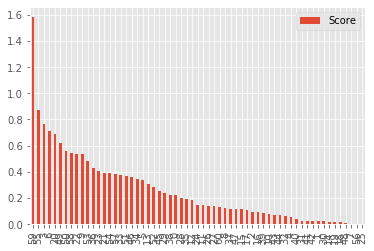

In [25]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [26]:
from sklearn.linear_model import SGDClassifier

#### SMOTE

In [27]:
# SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline recall score:  1.0


In [28]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(1e-4,1e-6,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.65 s, sys: 155 ms, total: 2.81 s
Wall time: 12.5 s


/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 9.65862069e-05, 9.31724138e-05, 8.97586207e-05,
       8.63448276e-05, 8.29310345e-05, 7.95172414e-05, 7.61034483e-05,
       7.26896552e-05, 6.92758621e-05, 6.58620690e-...
       5.90344828e-05, 5.56206897e-05, 5.22068966e-05, 4.87931034e-05,
       4.53793103e-05, 4.19655172e-05, 3.85517241e-05, 3.51379310e-05,
       3.17241379e-05, 2.83103448e-05, 2.48965517e-05, 2.14827586e-05,
       1.80689655e-05, 1.46551724e-05, 1.12413793e-05, 7.82758621e-06,
       4.41379310e-06, 1.00000000e-06]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [29]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 1e-06, 'max_iter': 1}
SGD Grid Search Training set recall score:  0.9223132530118658
SGD Best Estimator Validation set recall score:  1.0
SGD Best Estimator Validation set business score:  0.49800071170395427


#### imblearn balanced

In [30]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline recall score:  1.0


In [31]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(1e-4,1e-6,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 2.61 s, sys: 137 ms, total: 2.74 s
Wall time: 13.1 s


/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 9.65862069e-05, 9.31724138e-05, 8.97586207e-05,
       8.63448276e-05, 8.29310345e-05, 7.95172414e-05, 7.61034483e-05,
       7.26896552e-05, 6.92758621e-05, 6.58620690e-...
       5.90344828e-05, 5.56206897e-05, 5.22068966e-05, 4.87931034e-05,
       4.53793103e-05, 4.19655172e-05, 3.85517241e-05, 3.51379310e-05,
       3.17241379e-05, 2.83103448e-05, 2.48965517e-05, 2.14827586e-05,
       1.80689655e-05, 1.46551724e-05, 1.12413793e-05, 7.82758621e-06,
       4.41379310e-06, 1.00000000e-06]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [32]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 4.413793103448272e-06, 'max_iter': 1}
SGD Grid Search Training set recall score:  0.9244159321315536
SGD Best Estimator Validation set recall score:  1.0
SGD Best Estimator Validation set business score:  0.5699785508346373


#### Comparing SMOTE with imblearn

In [33]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.49800071170395427 
imblearn SGD business score:  0.5699785508346373


In [34]:
recall_scores.loc[1] = 'SGD', round(SMOTE_sgd, 2)

#### SGD feature Importance

,Feature,Score
59,Outpatient,847.874570
5,Inpatient_Count,727.827988
43,Procedure_1_Count,699.965899
12,Avg_Cost,598.657120
18,Race3,580.777279
...,...,...
47,Procedure_5_Count,12.428256
38,ChronicCond_stroke_1,8.509102
20,ChronicCond_Alzheimer_1,2.113747
26,ChronicCond_ObstrPulmonary_1,2.024652


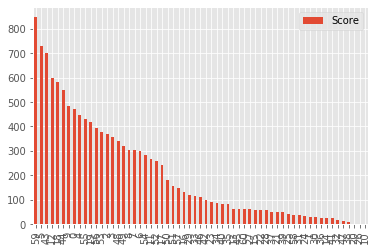

In [35]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

#### SMOTE

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.9979607443283202
KNN Baseline Validation Set recall score:  0.8316831683168316


In [37]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = business_score)

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [38]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.9418812133571246
KNN Grid Search Validation set Recall score:  0.9306930693069307
KNN Grid Search Validation set business score:  0.680518747977786


#### imblearn

In [39]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set recall score: ", recall_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set recall score:  1.0
KNN Baseline Validation Set recall score:  0.7722772277227723


In [40]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = business_score)

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [41]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.9013510068824879
KNN Grid Search Validation set Recall score:  0.9207920792079208
KNN Grid Search Validation set business score:  0.6902461376795336


#### Comparing SMOTE and imblearn

In [42]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.680518747977786 
imblearn KNN business score:  0.6902461376795336


In [43]:
recall_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

In [44]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[825, 156],
       [  8,  93]])

### Support Vector Machine

#### SMOTE

In [45]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [46]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SMOTE: 
SVM BaseLine Train Set Recall Score: 0.8924292633188886
SVM BaseLine Validation Set Recall Score: 0.8910891089108911


In [47]:
# grid search 
params = {'C': np.logspace(0,3,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = business_score)
svm_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [48]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 100.0, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.9938822329849605
SVM Grid Search Validation set Recall score:  0.26732673267326734
Test Set business Score: -0.5788500502056962


#### imblearn

In [49]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

SVC(class_weight='balanced')

In [50]:
# baseline score
svm_train_recall = recall_score(y_ros, svm.predict(X_ros))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

imblearn: 
SVM BaseLine Train Set Recall Score: 0.8835075197552893
SVM BaseLine Validation Set Recall Score: 0.8910891089108911


In [51]:
# grid search 
params = {'C': np.logspace(-1,3,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = business_score)
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [52]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 1000.0, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.99923527912312
SVM Grid Search Validation set Recall score:  0.26732673267326734
Test Set business Score: -0.5760816717775931


#### Comparing SMOTE and imblearn

In [53]:
print('SMOTE svm business score: ', SMOTE_svm, '\nimblearn svm business score: ', imblearn_svm)

SMOTE svm business score:  -0.5788500502056962 
imblearn svm business score:  -0.5760816717775931


In [54]:
recall_scores.loc[3] = 'SVC', round(SMOTE_svm, 2)

In [55]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))

array([[935,  46],
       [ 74,  27]])

### Discriminant Analysis

#### SMOTE

In [56]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [57]:
y_predict = LDA.predict(X_test)
print("SMOTE: \nLDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

SMOTE: 
LDA Baseline validation set recall score:  0.900990099009901
LDA Baseline validation set business score:  0.558362896346721


In [58]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.5247524752475248
QDA Baseline validation set business score:  -0.04092874482298815


/Users/marcuschoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Random Forest

In [59]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.7029702970297029


In [60]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 8.13 s, sys: 386 ms, total: 8.51 s
Wall time: 4min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [61]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 100}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.7425742574257426
RF Grid Search Validation set Business score:  0.40855671167396346


Text(0.5, 0, 'Random Forest Feature Importance')

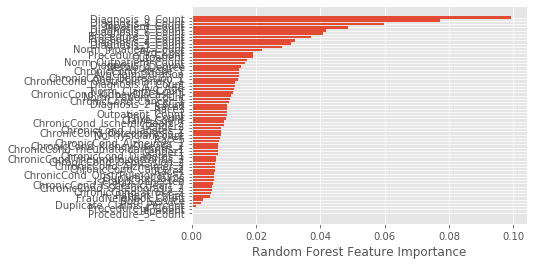

In [62]:
#plt.barh(X_train_Bal.columns, best_RF.feature_importances_)
sorted_idx = best_RF.feature_importances_.argsort()
plt.barh(X_train_Bal.columns[sorted_idx], best_RF.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [63]:
# feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))
# test2 = 
# # summarize feature importance
# for i,v in enumerate(importance):
#     feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
list_of_tuples = list(zip(X_train_Bal.columns, best_RF.feature_importances_)) 
df = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Score']) 

# Assign data to tuples. 
df.sort_values(by='Score', ascending=False)

,Feature,Score
56,Diagnosis_9_Count,0.099086
55,Diagnosis_8_Count,0.077179
5,Inpatient_Count,0.059908
54,Diagnosis_7_Count,0.048666
53,Diagnosis_6_Count,0.041667
...,...,...
57,Both_Service,0.003542
10,Duplicate_Claims_Percent,0.002990
46,Procedure_4_Count,0.001385
58,Inpatient,0.000130


#### imblearn

In [64]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.6237623762376238


In [65]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 6.76 s, sys: 397 ms, total: 7.16 s
Wall time: 2min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [66]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 28, 'n_estimators': 60}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.6732673267326733
RF Grid Search Validation set Business score:  0.2874759136658117


#### comparing SMOTE and imblearn

In [67]:
print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)

SMOTE rf business score:  0.40855671167396346 
imblearn rf business score:  0.2874759136658117


In [68]:
recall_scores.loc[4] = 'RF', round(SMOTE_rf, 2)

### XG BOOST 

In [69]:
from xgboost import XGBClassifier

#SMOTE
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
print('SMOTE: \nXGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set Recall Score: 0.99974509304104
XGB BaseLine Validation Set Recall Score: 0.5742574257425742


In [71]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [100,200,300],
                 'learning_rate': [0.1, 1, 1.5],
                 'n_estimators': [5,10,13] ,
                 'max_depth': [1,3,5],
                 'subsample': [0.9]
                 } 

In [72]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.46 s, sys: 152 ms, total: 2.61 s
Wall time: 18.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [73]:
grid_search_xgb.best_params_

{'learning_rate': 1,
 'max_depth': 5,
 'n_estimators': 5,
 'scale_pos_weight': 200,
 'subsample': 0.9}

In [74]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9504950495049505
XGB BaseLine Validation Set business Score: 0.6223066705808462


#### imblearn

In [75]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set Recall Score:', recall_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.6039603960396039


In [76]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [100,150,200],
                 'learning_rate': [0.5, 1, 1.5],
                 'n_estimators': [15,17,20] ,
                 'max_depth': [7,10,15],
                 'subsample': [0.9]
                 } 
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 3.5 s, sys: 141 ms, total: 3.65 s
Wall time: 59.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [77]:
grid_search_xgb.best_params_

{'learning_rate': 1.5,
 'max_depth': 10,
 'n_estimators': 20,
 'scale_pos_weight': 150,
 'subsample': 0.9}

In [78]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.6831683168316832
XGB BaseLine Validation Set business Score: 0.2666750102516514


#### comparing SMOTE and imblearn

In [79]:
print('SMOTE xgb business score: ', SMOTE_xgb, '\nimblearn xgb business score: ', imblearn_xgb)

SMOTE xgb business score:  0.6223066705808462 
imblearn xgb business score:  0.2666750102516514


In [80]:
recall_scores.loc[5] = 'XGBoost', round(SMOTE_xgb, 2)

In [81]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[905,  76],
       [ 32,  69]])

,Model,Score
0,Logistic,0.68
1,SGD,0.50
2,KNN,0.68
3,SVC,-0.58
4,RF,0.41
5,XGBoost,0.62


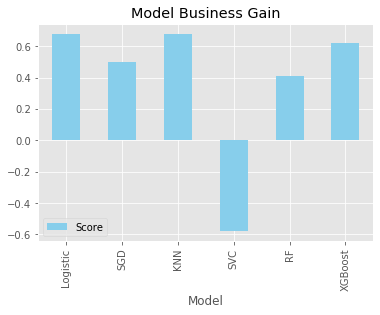

In [82]:
recall_scores.plot.bar(x = 'Model', color = 'skyblue')
plt.title('Model Business Gain')
recall_scores